In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import r2_score

from numpy.linalg import inv

# Защита персональных данных клиентов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Требуется разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию и обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

Загрузим и осмотрим наши данные.

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.shape

(5000, 5)

In [4]:
display(df.head())
print(df.info())
print('+'*50)
print(f'Повторяющихся строк: {df.duplicated().sum()} что составляет {(df.duplicated().sum() / df.shape[0]):.2%}' )
print('+'*50)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
None
++++++++++++++++++++++++++++++++++++++++++++++++++
Повторяющихся строк: 153 что составляет 3.06%
++++++++++++++++++++++++++++++++++++++++++++++++++


Имеется 3% повторенных строк. Так как у нас нет уникальных идентификаторов для каждого клиента, мы не можем однозначно сказать являются ли эти строки ошибкой или просто так совпало, что есть люди одного возраста с одинаковой зарплатой и одинаковым количеством членов семьи. 

Для дальнейшего удобства работы переименуем столбцы.

In [5]:
df.columns = ['gender', 'age', 'salary', 'family_members', 'insurance_paiments']

Напишем функцию для осмотра нашего датасета.

In [6]:
def histogram_boxplot(data,
                      xlabel=None,
                      title=None,
                      font_scale=1,
                      figsize=(16, 8),
                      bins=None):
    """ Диграмма размаха и гистограмма будут отрисованны вместе на одном кадре. 
    На графиках будут также нарисованны линия среднего и медианы.
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 1)
    figsize: size of fig (default (16, 8))
    bins: number of bins (default None / auto)
    """
    
    sns.set(font_scale=font_scale)
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)},
        figsize=figsize
    )
    sns.boxplot(x=data, ax=ax_box2)
    
    if bins:
        sns.histplot(x=data, ax=ax_hist2, bins=bins, kde=True)
    else:
        sns.histplot(data, ax=ax_hist2, kde=True)

    plt.axvline(x=data.mean(), linewidth=2, color='r', label="mean", alpha=0.8)
    plt.axvline(x=data.median(),
                linewidth=2,
                color='y',
                label="median",
                alpha=0.8)
    ax_hist2.legend()

    if xlabel:
        ax_hist2.set(xlabel=xlabel)
    if title:
        ax_box2.set(title=title)
    plt.show()    

In [7]:
def info_column(column_name, data, bins=None):
    
    '''Функция смотри тип данных в столбце:
    - если тип object, то смотрит уникальные значения
    - в противном случае оценивается распределение'''
    
    if column_name.dtype == 'object':
        
        print(column_name.name)
        print(column_name.unique())
        print()
        print(column_name.describe())
        print()
        
    else:
        bins=bins
        print(column_name.name)
        print(column_name.describe())
        histogram_boxplot(column_name, xlabel=column_name.name, title = 'Распределение '+ column_name.name)    

gender
count    5000.000000
mean        0.499000
std         0.500049
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64


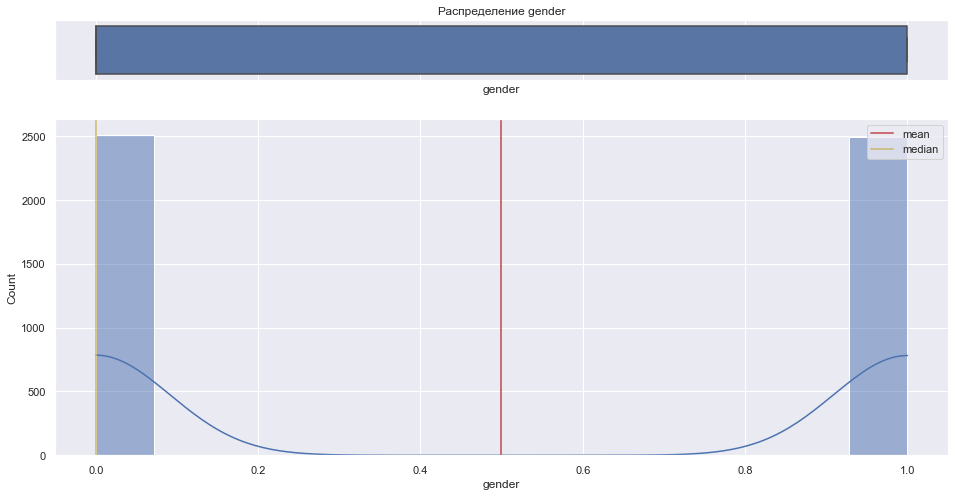

age
count    5000.000000
mean       30.952800
std         8.440807
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: age, dtype: float64


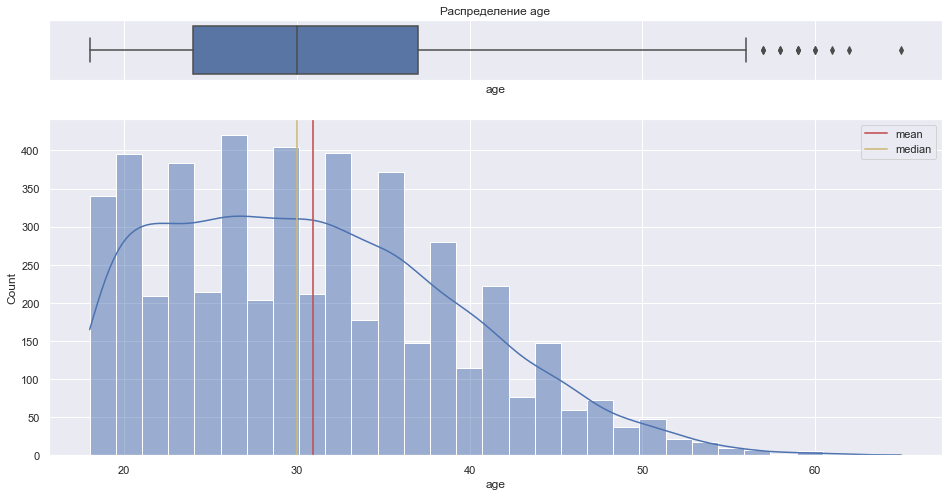

salary
count     5000.000000
mean     39916.360000
std       9900.083569
min       5300.000000
25%      33300.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: salary, dtype: float64


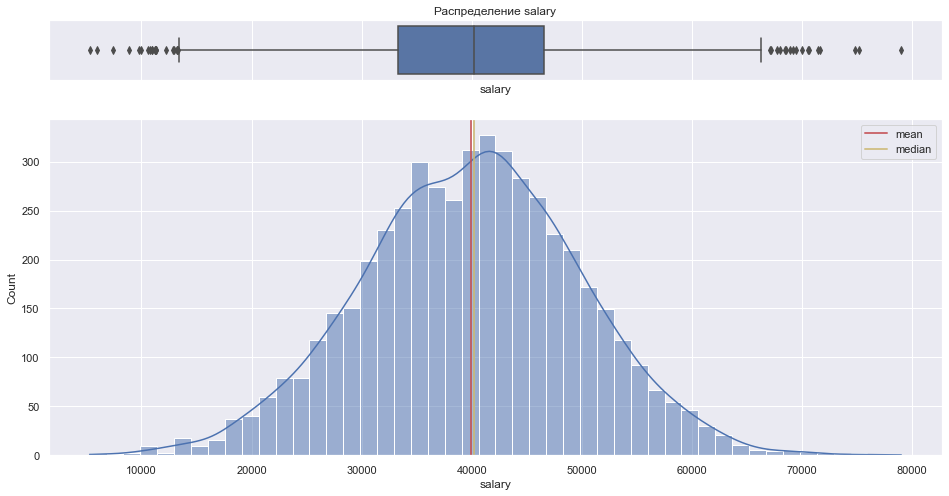

family_members
count    5000.000000
mean        1.194200
std         1.091387
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: family_members, dtype: float64


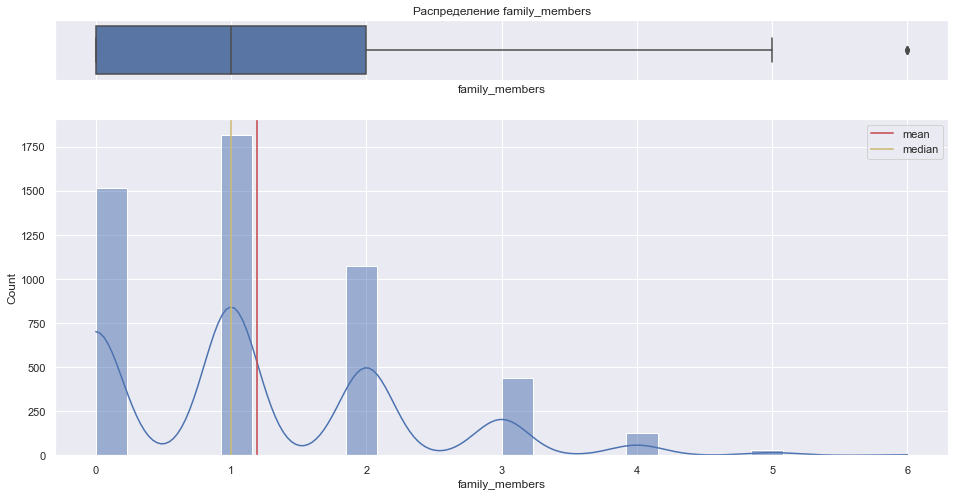

insurance_paiments
count    5000.000000
mean        0.148000
std         0.463183
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: insurance_paiments, dtype: float64


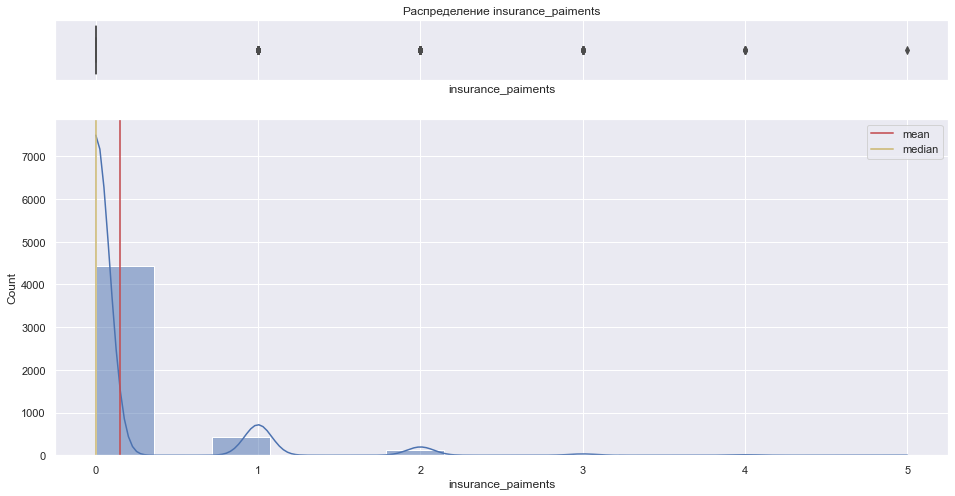

In [8]:
for column in df.columns:
    info_column(df[column], df)

In [9]:
not_applied = df.loc[df['insurance_paiments']==0]['insurance_paiments'].count()/df.shape[0]
print(f'За страховой выплатой обратились {1-not_applied:.2%} от общего числа застрахованных.')

За страховой выплатой обратились 11.28% от общего числа застрахованных.


**Выводы из осмотра данных:**

1. В нашей таблице примерно поровну мужчин и женщин. Неопределившихся нет.
2. Страховку покупают все начиная с совершеннолетия и до пенсии. Активнее всего страховыми продуктами интересуются люди от 24 (первая квантиль) до 37 (третья квантиль) лет.
3. Распределение зарплат застрахованных похоже на нормальное. По всей видимости выборку специально делали для какого-то среднего класса клиентов.
4. Больше всего в выборке представлены члены семейных пар без детей, следом за ними одинокие. С увеличением детей в нашей выборке падает количество покупок страховых продуктов.
5. 88% застрахованных никогда не обращались за страховой выплатой.

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

**Ответ:** Не изменится.

**Обоснование:** 
У нас имеется задача линейной регрессии $a=Xw$. Докажем, что если мы домножим матрицу $X(N,M)$ на обратимую матрицу $Z(N,N)$, то при вычислении весов $w=(X^TX)^{-1}X^Ty$ предсказания $a$ не изменятся.

Для доказательства подставим $Z$ в формулу вычисления весов.

$$w_{new}=((XZ)^TXZ)^{-1}(Xz)^Ty$$

Теперь подставим $w_{new}$ в формулу расчета предсказаний $a_{new}$, не забывая так же домножить уже имеющуюся матрицу $X$ на $Z$.

$$a_{new}=XZw_{new}=XZ((XZ)^TXZ)^{-1}(XZ)^Ty$$

Расскроем скобки. Для этого воспользуемся следующими свойствами матриц:
1. $(AB)^T=B^TA^T$
2. $(AB)^{-1} = B^{-1}A^{-1}$ - ***данное равенство верно только для двух квадратных обратимых матриц***
3. $AA^{-1}=A^{-1}A=E$, где $E$ - единичная матрица.
4. $AE=EA=A$

$$a_{new} = XZ((XZ)^TXZ)^{-1}(XZ)^Ty = \\\\XZ(Z^TX^T XZ)^{-1}Z^TX^Ty = \\\\XZ(X^TXZ)^{-1}(Z^T)^{-1}Z^TX^Ty = \\\\XZZ^{-1}(X^TX)^{-1}(Z^T)^{-1}Z^TX^Ty = \\\\XE(X^TX)^{-1}EX^Ty = \\\\X(X^TX)^{-1}X^Ty =  Xw$$

Из этого следует, что $a_{new}=Xw=a$

*ВАЖНО!*
Все эти преобразования имеют силу только если матрица $X^TX$ - обратима. В общем случае она таковой может и не быть.

## Алгоритм преобразования

**Алгоритм**

Для защиты данных мы будем домножать входную матрицу параметров на квадратную обратимую матрицу, которую мы сгенерируем случайным образом. Реализуем это через специальный класс.

In [10]:
class DefendViaMatrix(TransformerMixin, BaseEstimator):
    
    
    def fit(self, X, y=None, random_state=None):
        if random_state:
            np.random.seed(random_state)
        Z = np.random.normal(size=(X.shape[1], X.shape[1]))
        try:
            np.linalg.inv(Z_1) #если сюда прописать матрицу Z_1, то сработает исключение и код повторится
        except:
            random_state += 1
            np.random.seed(random_state)
            Z = np.random.normal(size=(X.shape[1], X.shape[1]))
        print(f'Random State for Z matrix is {random_state}')
        self.Z = Z
        self.X = X
        print('Z matrix is invertible')
        return self
        
    
    def transform(self, X, y=None):
        return X.dot(self.Z)

## Проверка алгоритма

Разделим наш датасет на признаки и целевой признак.

In [11]:
X = df.drop(columns='insurance_paiments')
y = df['insurance_paiments']

X.shape, y.shape

((5000, 4), (5000,))

Теперь преобразуем наши признаки воспользовавшись написанным нами классом.

In [12]:
X_new = DefendViaMatrix().fit_transform(X, random_state=42)
X.shape, X_new.shape

Random State for Z matrix is 43
Z matrix is invertible


((5000, 4), (5000, 4))

In [13]:
X_new.head()

,0,1,2,3
0,62671.702352,-21803.760877,-17162.779353,22665.614054
1,48026.541403,-16710.025106,-13141.230348,17394.491915
2,26544.976562,-9235.489284,-7260.748284,9620.008629
3,52676.008621,-18325.656912,-14435.012356,19028.795361
4,32984.969766,-11475.980525,-9028.458230,11939.593778


Как мы видим все получилось. Обучим две линейные регрессии и сравним для них метрики R2.

In [14]:
lr_clsfr = LinearRegression()

lr_clsfr.fit(X, y)
predict1 = lr_clsfr.predict(X)

lr_clsfr.fit(X_new, y)
predict2 = lr_clsfr.predict(X_new)

print(r2_score(y, predict1))
print(r2_score(y, predict2))

print(r2_score(y, predict1) - r2_score(y, predict2))

0.4249455028666801
0.42494550286673605
-5.595524044110789e-14


## Вывод:

Разница между значениями метрик стремится к нулю, следовательно мы можем безбоязненно применять написанный нами класс для защиты данных и такие преобразования не навредят результатам моделей линейной регрессии.